# Importações

In [31]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import shutil

# Coleta Metadados

In [32]:
metadados_path = os.path.join("..","datasets","PH2Dataset","PH2_dataset.xlsx")

In [33]:
df = pd.read_excel(metadados_path,header=12)

In [34]:
df.head()

,Image Name,Histological Diagnosis,Common Nevus,Atypical Nevus,Melanoma,Asymmetry\n(0/1/2),Pigment Network\n(AT/T),Dots/Globules\n(A/AT/T),Streaks\n(A/P),Regression Areas\n(A/P),Blue-Whitish Veil\n(A/P),White,Red,Light-Brown,Dark-Brown,Blue-Gray,Black
0,IMD003,NaN,X,NaN,NaN,0,T,A,A,A,A,NaN,NaN,NaN,X,NaN,NaN
1,IMD009,NaN,X,NaN,NaN,0,T,A,A,A,A,NaN,NaN,X,NaN,NaN,NaN
2,IMD016,NaN,X,NaN,NaN,0,T,T,A,A,A,NaN,NaN,X,X,NaN,NaN
3,IMD022,NaN,X,NaN,NaN,0,T,A,A,A,A,NaN,NaN,X,NaN,NaN,NaN
4,IMD024,NaN,X,NaN,NaN,0,T,A,A,A,A,NaN,NaN,X,X,NaN,NaN


# Visualização das Classes

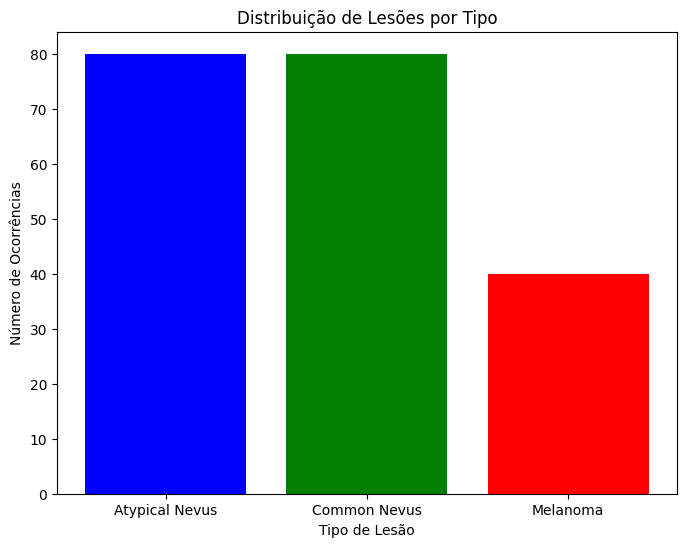

In [35]:
contagem_atypical = df[df["Atypical Nevus"] == "X"].shape[0]
contagem_common = df[df["Common Nevus"] == "X"].shape[0]
contagem_melanoma = df[df["Melanoma"] == "X"].shape[0]


categorias = ["Atypical Nevus", "Common Nevus", "Melanoma"]
contagens = [contagem_atypical, contagem_common, contagem_melanoma]

plt.figure(figsize=(8, 6))  
plt.bar(categorias, contagens, color=['blue', 'green', 'red'])

plt.title("Distribuição de Lesões por Tipo")
plt.xlabel("Tipo de Lesão")
plt.ylabel("Número de Ocorrências")

plt.show()

# Pipeline Dataframe

In [36]:
indiceRemover = list(df.columns).index("Asymmetry\n(0/1/2)")

def limparColunas(X):
    df1 = X.iloc[:, :indiceRemover]
    df1["classificacao"] = df1.apply(lambda row: 'maligno' if row['Melanoma'] == "X" else 'benigno',axis=1)
    df1.drop(['Melanoma','Atypical Nevus','Common Nevus',"Histological Diagnosis"],inplace=True,axis=1)
    return df1

In [37]:
def dividir_treino_validacao(DF):
    X = DF.drop("classificacao",axis=1)
    y = DF.drop("Image Name",axis=1)
    X_train,X_val,y_train,y_val = train_test_split(X,y,random_state=42,test_size=0.2,stratify=y)
    return X_train,X_val,y_train,y_val

In [38]:
pipeline = Pipeline([
    ("limpa",FunctionTransformer(limparColunas)),
    ("divide",FunctionTransformer(dividir_treino_validacao))
])

In [39]:
X_train,X_val,y_train,y_val = pipeline.fit_transform(df)

# Estrutura de Pastas

### Criar uma pasta apenas com as imgens originais (sem a estrutura de pastas original)

In [44]:
original_imgs_path = os.path.join("..","datasets","PH2Dataset","PH2 Dataset images")
flatten_copy = os.path.join("..","datasets","PH2Imagens")
os.makedirs(flatten_copy,exist_ok=True)
for img_dir in os.listdir(original_imgs_path):
    lista = os.listdir(f"{os.path.join(original_imgs_path,img_dir)}")
    imagem_original_dir = lista[lista.index(f"{img_dir+'_Dermoscopic_Image'}")]
    
    shutil.copy2(os.path.join(original_imgs_path,img_dir,imagem_original_dir,f"{img_dir}.bmp"),flatten_copy)

### Função para criar uma estrutura de pastas de acordo com o keras

In [70]:
def estruturar_pastas(src,destino):
    classes = y_train["classificacao"].unique()

    os.makedirs(destino,exist_ok=True)
    os.makedirs(os.path.join(destino,"treino"),exist_ok=True)
    os.makedirs(os.path.join(destino,"validacao"),exist_ok=True)

    for categoria in classes:
        os.makedirs(os.path.join(destino,"treino",categoria),exist_ok=True)
        os.makedirs(os.path.join(destino,"validacao",categoria),exist_ok=True)

    img_filenames_benignas_treino = X_train[y_train["classificacao"]=="benigno"].apply(lambda img_name : img_name+".bmp").values
    img_filenames_malignas_treino = X_train[y_train["classificacao"]=="maligno"].apply(lambda img_name : img_name+".bmp").values
    
    img_filenames_benignas_val = X_val[y_val["classificacao"]=="benigno"].apply(lambda img_name : img_name+".bmp").values
    img_filenames_malignas_val = X_val[y_val["classificacao"]=="maligno"].apply(lambda img_name : img_name+".bmp").values

    filenames_classes = [img_filenames_benignas_treino,img_filenames_malignas_treino,img_filenames_benignas_val,img_filenames_malignas_val]
    for filenames_class,DIR in zip(filenames_classes,["treino/benigno","treino/maligno","validacao/benigno","validacao/maligno"]):
        for filename in filenames_class:
            shutil.copy2(os.path.join(src,filename[0]),os.path.join(destino,DIR))

In [71]:
estruturar_pastas(src = os.path.join("..","datasets","PH2Contornado"),destino = os.path.join("..","datasets","PH2Contornado_estruturado"))

In [72]:
estruturar_pastas(src = flatten_copy,destino = os.path.join("..","datasets","PH2_estruturado"))